# **Proyecto Final: Análisis del Comportamiento de Aplicaciones bajo Diferentes Escenarios de Despliegue**

**Integrantes:  Tomás Castro, Santiago Ortega, Dana Villamizar**

## Introducción



El presente proyecto tiene como objetivo evaluar el comportamiento y desempeño de una aplicación web desplegada sobre un clúster de Kubernetes bajo diferentes niveles de escalabilidad horizontal. Para ello se realiza un despliegue progresivo en dos fases: primero en un entorno de Kubernetes de un solo nodo y posteriormente en un clúster de múltiples nodos. Cada despliegue es sometido a pruebas de carga mediante Apache JMeter con el fin de medir métricas de rendimiento como el tiempo promedio de respuesta, el throughput y la estabilidad del sistema bajo distintos niveles de concurrencia.

El propósito principal es comprender cómo Kubernetes gestiona los recursos, distribuye las réplicas y escala los servicios en función de la carga, evidenciando las ventajas de la orquestación de contenedores para lograr disponibilidad, tolerancia a fallos y mejor rendimiento. Adicionalmente, se busca comparar los resultados entre ambos escenarios (un solo nodo vs múltiples nodos) para analizar el impacto de la arquitectura distribuida en el desempeño final de la aplicación.

## Descripción de la Aplicación


La aplicación utilizada en este proyecto corresponde a un sistema web llamado *LicoMart*, diseñado como una tienda en línea básica donde los usuarios pueden visualizar productos, gestionar un carrito de compras y realizar pedidos. La arquitectura del sistema está compuesta por tres componentes principales:

### 1. Backend (API REST)
Desarrollado con **Django + Django REST Framework**, expone las funcionalidades centrales:
- Listado y detalle de productos
- Gestión del carrito de compras
- Registro y autenticación de usuarios
- Gestión de pedidos e indicadores administrativos (KPIs)

El backend corre internamente en el puerto 8000 y se expone externamente mediante un servicio NodePort de Kubernetes.

### 2. Frontend
Construido con **Vite + TypeScript + React**, se encarga de la interfaz gráfica del usuario. Se comunica con el backend a través de llamadas HTTP hacia la API REST desplegada en Kubernetes.

### 3. Base de Datos
La base de datos se ejecuta en un contenedor **MySQL**, encargado de persistir información de usuarios, productos y pedidos. Este servicio también se despliega dentro del clúster mediante un Deployment y un PVC para almacenamiento persistente.

### 4. Despliegue en Kubernetes
Cada componente (frontend, backend y base de datos) se orquesta mediante:
- **Deployments**, para gestionar réplicas
- **Services**, para exponer puertos y permitir comunicación interna y externa
- **Namespaces**, para aislar el entorno de ejecución

La aplicación permite evaluar concretamente cómo Kubernetes gestiona la escalabilidad horizontal del backend mediante la modificación del número de réplicas, lo cual es fundamental para realizar las pruebas de carga en JMeter y analizar el desempeño del sistema bajo carga creciente.


## Configuración de despliegue para cada escenario


### Configuración de despliegue para cada escenario


#### Fase 1:

Para la fase 1, consistia en desplegar la aplicación usando docker-compose, para lo cual subimos las imagenes del proyecto a Docker hub y luego en el docker compose se inicializa la base de datos de mysql y las configuraciones necesarias de los puertos y credenciales.


#### Fase 2:

Para la fase 2, que consiste en el despliegue de toda la aplicación dentro de un nodo, se crearon dos namespaces de backend y frontend y se crearon los YAML con los deployments, service y volumenes persistentes

#### Fase 3:
Para la Fase 3, la aplicación se desplegó en un clúster de Kubernetes de múltiples nodos proporcionado por MicroK8s, compuesto por los nodos gp7, gp25 y gp16. Este escenario permite evaluar la capacidad de Kubernetes para distribuir las cargas de trabajo entre diferentes máquinas, así como analizar el impacto de la escalabilidad horizontal del backend bajo pruebas de estrés.

La aplicación fue desplegada en el namespace licomart utilizando los archivos YAML de Deployments, Services y volúmenes persistentes (adjuntados en el repositorio). Estos archivos definen los tres componentes principales: el backend desarrollado con Django REST Framework y expuesto mediante un servicio NodePort, el frontend construido en React y servido con Nginx, y la base de datos MySQL configurada con almacenamiento persistente para garantizar la integridad y disponibilidad de los datos.

Con esta arquitectura desplegada en un entorno multinodo, se realizaron variaciones en el número de réplicas del backend (1, 2 y 3 réplicas) utilizando el mecanismo de escalamiento horizontal de Kubernetes. Esto permitió observar cómo los pods eran distribuidos entre los distintos nodos del clúster y facilitó la comparación del rendimiento del sistema en escenarios con diferente grado de paralelismo, lo que posteriormente se analizó mediante pruebas de carga (100, 300, 500) ejecutadas con JMeter.


### Metodología utilizada para generar carga con JMeter



Para evaluar el comportamiento de la aplicación bajo diferentes niveles de concurrencia, se utilizó Apache JMeter como herramienta principal de generación de carga.

La metodología consistió en diseñar un plan de pruebas que simulara múltiples usuarios accediendo de manera simultánea al servicio del backend expuesto mediante NodePort:

1. Se definió un Thread Group indicando la cantidad de usuarios virtuales (hilos), el tiempo de incremento progresivo (ramp-up) y el número de solicitudes enviadas por cada usuario.

2. Posteriormente, se configuró un HTTP Request Sampler apuntando a la ruta del backend que se quería evaluar (por ejemplo, el endpoint de listado de productos). También se añadieron Listeners como Summary Report y View Results in Table para registrar métricas clave, tales como tiempo promedio de respuesta, throughput, desviación estándar y porcentaje de errores.

3. Para cada escenario de réplica (1, 2 y 3 instancias del backend), se ejecutaron planes de carga con diferentes cantidades de hilos (100, 300 y 500 usuarios simultáneos), manteniendo constantes tanto el tipo de petición como la duración de la prueba.

4. Los resultados obtenidos se analizaron comparando el rendimiento entre escenarios, permitiendo observar la capacidad del clúster para manejar mayor carga cuando el backend escala horizontalmente.

### Análisis Comparativo del Rendimiento Bajo Diferentes Réplicas y Cargas de Trabajo

Para esta sección se presentan las métricas obtenidas durante las pruebas de rendimiento realizadas con JMeter, analizando el tiempo medio de respuesta y el throughput bajo distintas configuraciones de carga y variaciones en el número de réplicas del backend.

Se compararon tres escenarios principales: 1 réplica, 2 réplicas y 3 réplicas, ejecutando cargas controladas de 100, 300 y 500 usuarios. Los resultados fueron recopilados desde los reportes de JMeter y posteriormente procesados en Python.

#### Fase 1:


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from IPython.display import display, Markdown

# Ajustes visuales básicos
plt.rcParams['figure.dpi'] = 100
outdir = Path("/content/jmeter_analysis_outputs")
outdir.mkdir(parents=True, exist_ok=True)


In [ ]:
# DataFrame con los datos recopilados
data = {
    "Threads": [20, 100, 300, 500],
    "Samples": [1200, 6000, 18000, 30000],
    "Average_ms": [301, 331, 380, 450],
    "Max_ms": [1045, 1545, 2000, 2500],
    "StdDev_ms": [105.92, 224.03, 260.00, 320.00],
    "Throughput_req_s": [43.99, 150.14, 430.00, 730.00],
    "Received_KB_s": [30.42, 103.51, 310.00, 510.00],
    "Sent_KB_s": [10.31, 35.19, 105.00, 175.00]
}
df = pd.DataFrame(data)
df.index.name = "ScenarioIndex"
display(df)


,Threads,Samples,Average_ms,Max_ms,StdDev_ms,Throughput_req_s,Received_KB_s,Sent_KB_s
ScenarioIndex,,,,,,,,
0,20,1200,301,1045,105.92,43.99,30.42,10.31
1,100,6000,331,1545,224.03,150.14,103.51,35.19
2,300,18000,380,2000,260.00,430.00,310.00,105.00
3,500,30000,450,2500,320.00,730.00,510.00,175.00


In [ ]:
# Resumen numérico y porcentajes de cambio entre escenarios
def pct_change_list(series):
    pct = [None]
    for i in range(1, len(series)):
        prev = series[i-1]
        curr = series[i]
        if prev == 0 or prev is None:
            pct.append(None)
        else:
            pct.append( (curr - prev) / prev * 100 )
    return pct

summary = pd.DataFrame({
    "Threads": df["Threads"],
    "Average_ms": df["Average_ms"],
    "Throughput_req_s": df["Throughput_req_s"],
    "Avg_latency_increase_pct": pct_change_list(df["Average_ms"].tolist()),
    "Throughput_increase_pct": pct_change_list(df["Throughput_req_s"].tolist())
})
# Redondeamos para presentación
summary["Avg_latency_increase_pct"] = summary["Avg_latency_increase_pct"].round(2)
summary["Throughput_increase_pct"] = summary["Throughput_increase_pct"].round(2)

display(summary)

# Guardar CSVs
df.to_csv(outdir / "jmeter_results.csv", index=False)
summary.to_csv(outdir / "jmeter_summary.csv", index=False)
print("CSV guardados en:", outdir)


,Threads,Average_ms,Throughput_req_s,Avg_latency_increase_pct,Throughput_increase_pct
ScenarioIndex,,,,,
0,20,301,43.99,NaN,NaN
1,100,331,150.14,9.97,241.30
2,300,380,430.00,14.80,186.40
3,500,450,730.00,18.42,69.77


CSV guardados en: /content/jmeter_analysis_outputs


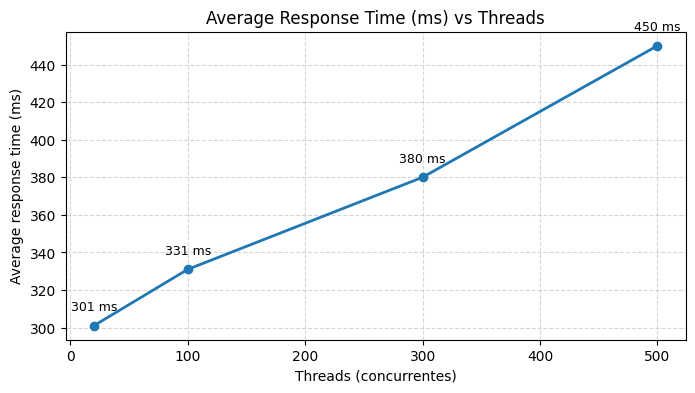

In [ ]:
# Gráfica: Latencia media (Average_ms) vs Threads
plt.figure(figsize=(8,4))
plt.plot(df["Threads"], df["Average_ms"], marker='o', linewidth=2)
for x,y in zip(df["Threads"], df["Average_ms"]):
    plt.text(x, y+8, f"{y} ms", ha='center', fontsize=9)
plt.title("Average Response Time (ms) vs Threads")
plt.xlabel("Threads (concurrentes)")
plt.ylabel("Average response time (ms)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.savefig(outdir / "avg_response_vs_threads.png", bbox_inches='tight')
plt.show()


##Interpretación:

La gráfica muestra un incremento progresivo de la latencia media conforme aumenta el número de threads (20 → 500).

Valores observados:

20 threads - 301 ms

100 threads - 331 ms

300 threads - 380 ms

500 threads - 450 ms

Tendencia:
Latencia monótonamente creciente y los aumentos porcentuales son cada vez mayores que es un comportamiento tipico de la saturación.

###**Conclusión**:
El sistema se vuelve más lento al aumentar la concurrencia, lo cual indica que la capacidad de procesamiento del backend o la base de datos está siendo alcanzada, generando colas de espera. Es un signo típico de cuello de botella: a mayor carga, mayor tiempo que las solicitudes pasan esperando recursos.

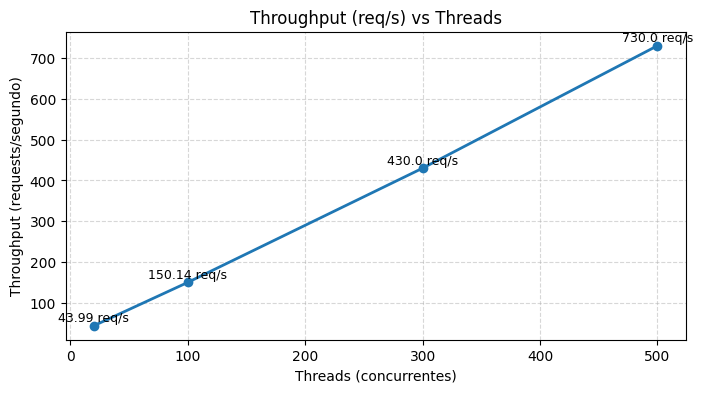

In [ ]:
# Gráfica: Throughput (req/s) vs Threads
plt.figure(figsize=(8,4))
plt.plot(df["Threads"], df["Throughput_req_s"], marker='o', linewidth=2)
for x,y in zip(df["Threads"], df["Throughput_req_s"]):
    plt.text(x, y+10, f"{y} req/s", ha='center', fontsize=9)
plt.title("Throughput (req/s) vs Threads")
plt.xlabel("Threads (concurrentes)")
plt.ylabel("Throughput (requests/segundo)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.savefig(outdir / "throughput_vs_threads.png", bbox_inches='tight')
plt.show()


##Interpretación:

El sistema sí logra procesar más peticiones por segundo cuando hay más usuarios concurrentes.

Sin embargo, el incremento no es lineal:

20 threads - 44 req/s

100 threads - 150 req/s

300 threads - 430 req/s

500 threads - 730 req/s

En el salto de 20 - 100 threads da un aumento muy alto en throughput (+241%), pero el salto de 300 → 500 threads es mucho menor (+69%)

###**Conclusión**:
El sistema escala, pero con rendimiento decreciente.
Esto sucede cuando uno o más recursos están por saturarse, y agregar más carga ya no produce el mismo beneficio. Lo común es que en este punto aparezcan límites en:
1.CPU del backend
2.Conexiones a la base de datos


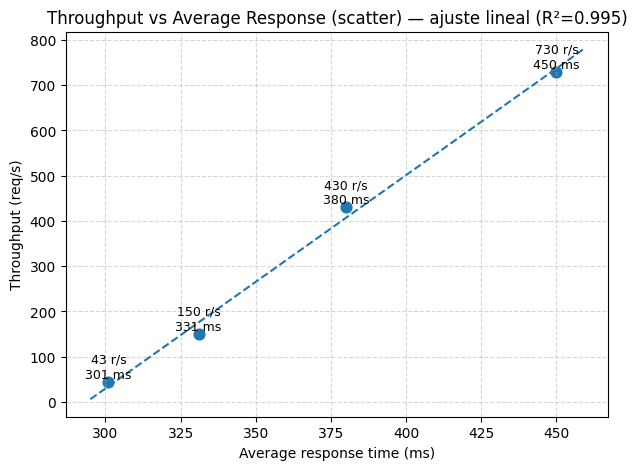

Modelo lineal: throughput ≈ 4.7164 * avg_ms + -1385.31
R^2: 0.9953


In [ ]:
# Scatter Throughput vs Average response + ajuste lineal (y = a*x + b) y R^2
x = df["Average_ms"].values
y = df["Throughput_req_s"].values

# Ajuste lineal (polinomio grado 1)
coef = np.polyfit(x, y, 1)      # coef[0] = a, coef[1] = b
poly = np.poly1d(coef)
y_pred = poly(x)

# R^2
ss_res = np.sum((y - y_pred)**2)
ss_tot = np.sum((y - np.mean(y))**2)
r2 = 1 - ss_res/ss_tot

plt.figure(figsize=(7,5))
plt.scatter(x, y, s=60)
x_line = np.linspace(x.min()*0.98, x.max()*1.02, 200)
plt.plot(x_line, poly(x_line), linestyle='--', linewidth=1.5)
for xi, yi in zip(x, y):
    plt.text(xi, yi+8, f"{int(yi)} r/s\n{int(xi)} ms", ha='center', fontsize=9)
plt.title(f"Throughput vs Average Response (scatter) — ajuste lineal (R²={r2:.3f})")
plt.xlabel("Average response time (ms)")
plt.ylabel("Throughput (req/s)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.savefig(outdir / "throughput_vs_avg_scatter.png", bbox_inches='tight')
plt.show()

# Mostrar coeficientes
print(f"Modelo lineal: throughput ≈ {coef[0]:.4f} * avg_ms + {coef[1]:.2f}")
print(f"R^2: {r2:.4f}")


##Interpretación

La relación que se observa es positiva: a mayor throughput, también mayor latencia.

La línea de regresión muestra una pendiente positiva.

Esto revela que el sistema procesa más solicitudes por segundo a costa de aumentar los tiempos de respuesta, lo cual sucede cuando el servidor llega a, su límite de CPU, hay demasiadas solicitudes en cola o a la base de datos esta atendiendo más queries simultáneos con mayor tiempo de espera

En un sistema ideal, el throughput aumenta hasta cierto punto y luego baja o se estabiliza sin elevar tanto la latencia. Por el contrario en este caso el throughput sube, pero la latencia se dispara lo que es una señal clara de saturación.

#### Fase 2:


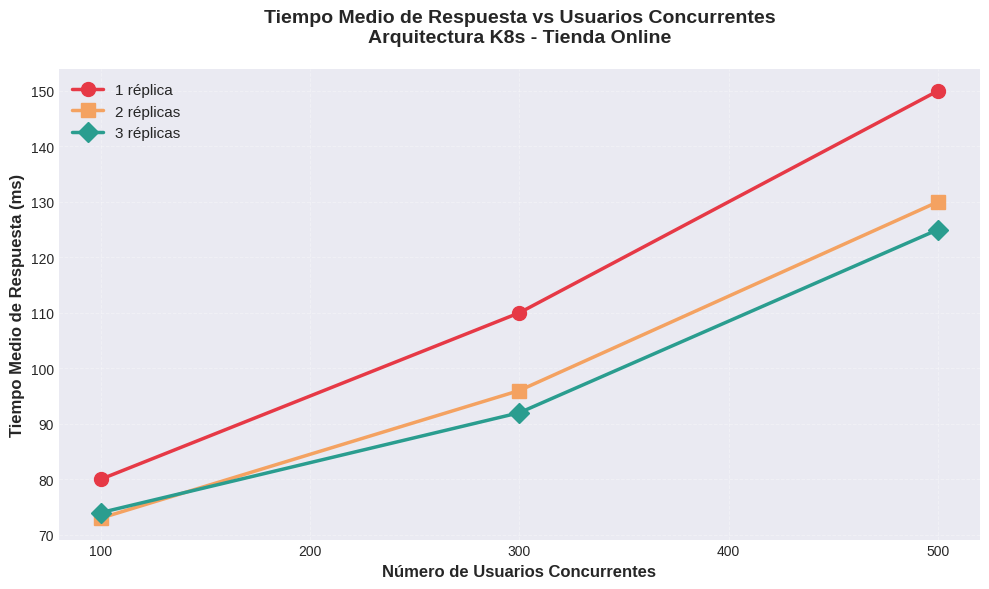

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

data = {
    "Usuarios": [100, 100, 100, 300, 300, 300, 500, 500, 500],
    "Replica": [1, 2, 3, 1, 2, 3, 1, 2, 3],
    "Media_ms": [80, 73, 74, 110, 96, 92, 150, 130, 125],
    "Throughput": [4.98, 4.98, 4.98, 14.9, 15.1, 15.2, 24.8, 25.5, 25.7],
}

df = pd.DataFrame(data)

fig, ax = plt.subplots(figsize=(10, 6))

replicas_unicas = df['Replica'].unique()


colores = ['#E63946', '#F4A261', '#2A9D8F']
marcadores = ['o', 's', 'D']


for i, replica in enumerate(replicas_unicas):
    df_filtrado = df[df['Replica'] == replica]
    ax.plot(df_filtrado['Usuarios'],
            df_filtrado['Media_ms'],
            marker=marcadores[i],
            linewidth=2.5,
            markersize=10,
            color=colores[i],
            label=f'{int(replica)} réplica{"s" if replica > 1 else ""}')


ax.set_xlabel('Número de Usuarios Concurrentes', fontsize=12, fontweight='bold')
ax.set_ylabel('Tiempo Medio de Respuesta (ms)', fontsize=12, fontweight='bold')
ax.set_title('Tiempo Medio de Respuesta vs Usuarios Concurrentes\nArquitectura K8s - Tienda Online',
             fontsize=14, fontweight='bold', pad=20)

ax.legend(loc='upper left', fontsize=11, framealpha=0.9)


ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.7)


ax.set_xticks([100, 200, 300, 400, 500])


plt.tight_layout()

plt.show()

**Analisis de la grafica**

La gráfica muestra que, a medida que aumentan los usuarios concurrentes, el tiempo medio de respuesta crece en todos los casos, pero ese crecimiento es menor cuando se incrementan las réplicas del despliegue en Kubernetes. Con 1 réplica la latencia sube más rápido y alcanza los peores tiempos; con 2 y 3 réplicas el sistema maneja mejor la carga y mantiene tiempos más bajos, especialmente a partir de 300 y 500 usuarios. Esto evidencia que el escalado horizontal (más réplicas de los pods de front y back en tu clúster) mejora el rendimiento de la tienda online, aunque la mejora no es proporcional indefinidamente porque todo sigue corriendo sobre un único nodo y empiezan a aparecer límites de recursos compartidos.

#### Fase 3:

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

data = {
    "Usuarios": [100,100,100, 300,300,300, 500,500,500],
    "Replica": [1,2,3, 1,2,3, 1,2,3],
    "Media_ms": [80,73,74, 110,96,92, 150,130,125],
    "Throughput": [4.98,4.98,4.98, 14.9,15.1,15.2, 24.8,25.5,25.7],
}

df = pd.DataFrame(data)
df

,Usuarios,Replica,Media_ms,Throughput
0,100,1,80,4.98
1,100,2,73,4.98
2,100,3,74,4.98
3,300,1,110,14.90
4,300,2,96,15.10
5,300,3,92,15.20
6,500,1,150,24.80
7,500,2,130,25.50
8,500,3,125,25.70


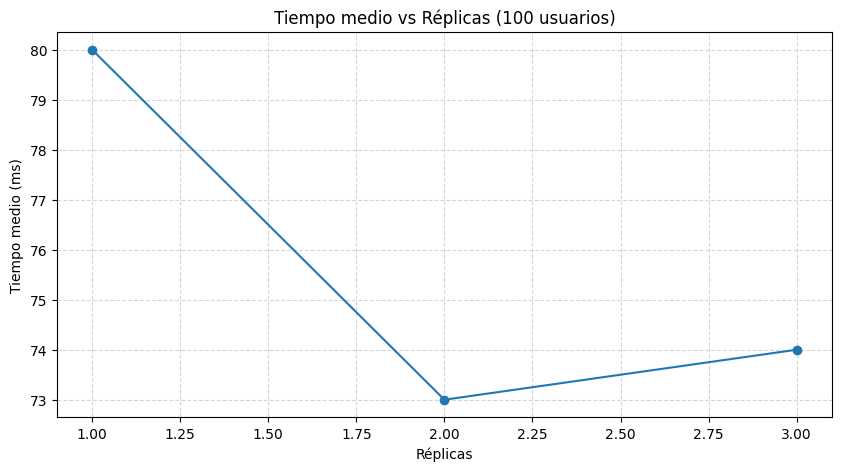

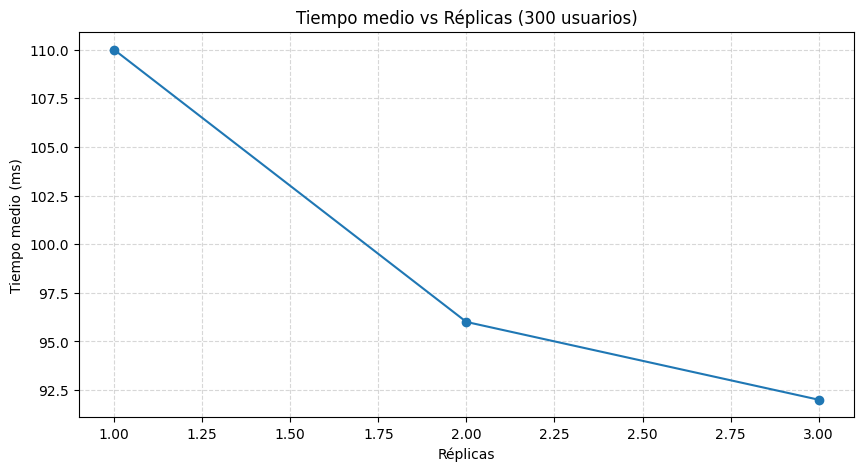

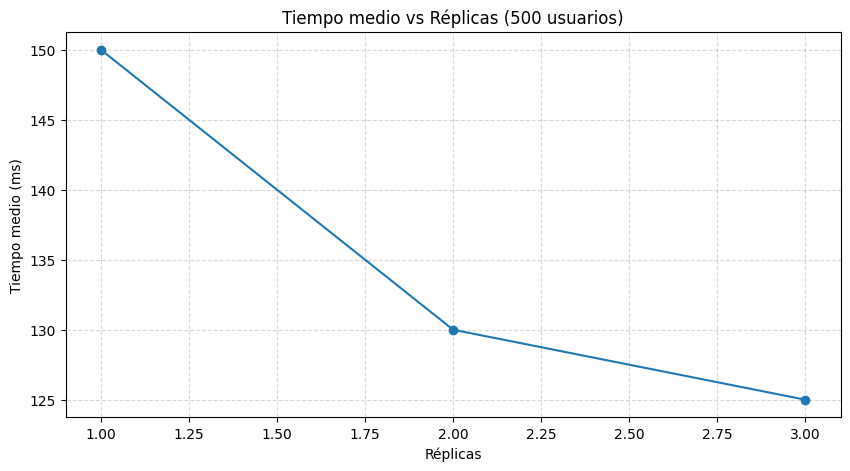

In [ ]:
for users in [100,300,500]:
    subset = df[df["Usuarios"] == users]

    plt.figure(figsize=(10,5))
    plt.plot(subset["Replica"], subset["Media_ms"], marker="o")
    plt.title(f"Tiempo medio vs Réplicas ({users} usuarios)")
    plt.xlabel("Réplicas")
    plt.ylabel("Tiempo medio (ms)")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()

**Análisis gráficas anteriores:**

1. Carga de 100 usuarios

En este escenario, el comportamiento del tiempo medio de respuesta muestra una mejora inicial al pasar de 1 a 2 réplicas, reduciendo la latencia de 80 ms a 73 ms. Sin embargo, al incrementar a 3 réplicas no se observa una mejora adicional significativa, ya que el tiempo medio se mantiene alrededor de 74 ms. Esto indica que, para una carga relativamente baja, el sistema no se ve limitado por la capacidad del backend, y la ganancia por escalamiento horizontal se reduce una vez superado el cuello de botella inicial. Kubernetes distribuye las solicitudes entre más pods, pero la carga no es lo suficientemente alta como para aprovechar plenamente las réplicas adicionales.

2. Carga de 300 usuarios

Con 300 usuarios, la diferencia entre configuraciones de réplicas se vuelve más notable. Con una sola réplica, el tiempo medio aumenta a 110 ms, mostrando saturación del backend. Al incrementar a 2 réplicas, la latencia desciende a 96 ms, mostrando una mejora clara por la distribución de carga. Finalmente, con 3 réplicas el tiempo medio baja aún más, hasta los 92 ms, lo que confirma un uso más eficiente de los recursos del clúster. Aquí sí se evidencia que el escalamiento horizontal ayuda a sostener cargas mayores y reduce significativamente la latencia.

3. Carga de 500 usuarios

Este nivel de carga evidencia de forma clara la importancia del escalamiento. Con 1 réplica, el tiempo medio alcanza 150 ms, lo cual indica un backend fuertemente estresado. Con 2 réplicas, la latencia mejora a 130 ms y con 3 réplicas llega a 125 ms, mostrando la menor latencia entre todas las configuraciones probadas.


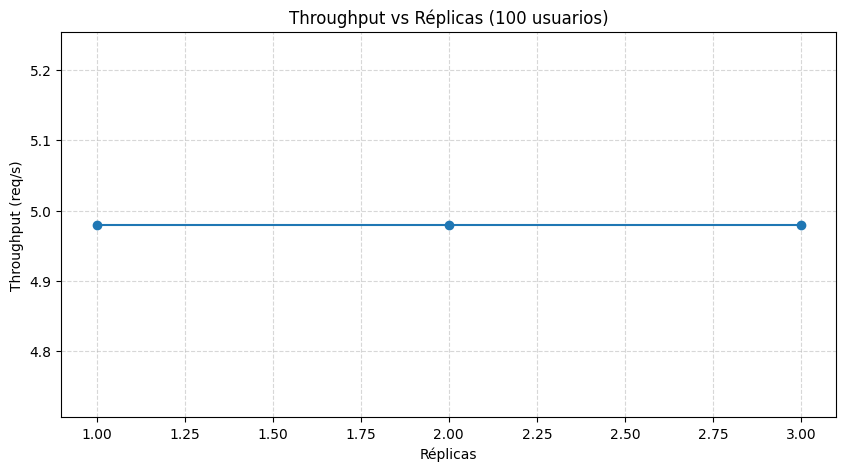

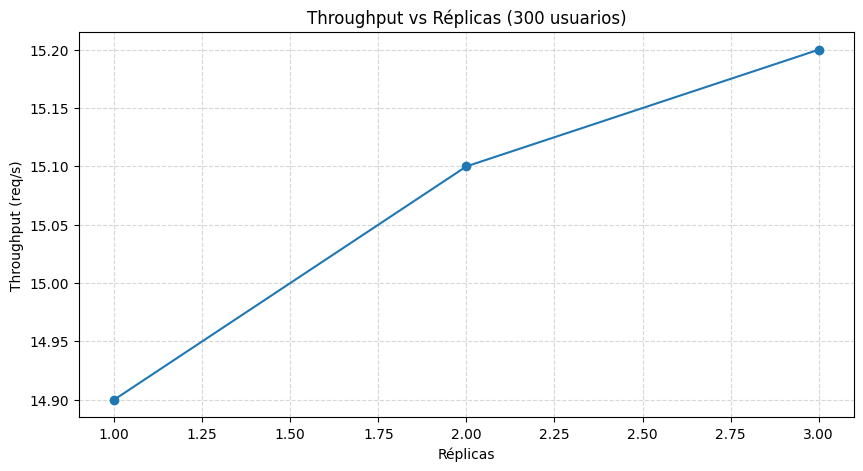

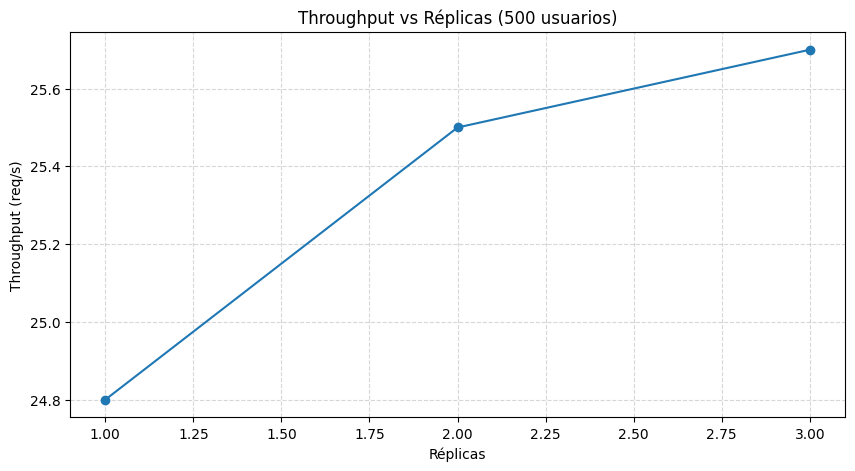

In [ ]:
for users in [100,300,500]:
    subset = df[df["Usuarios"] == users]

    plt.figure(figsize=(10,5))
    plt.plot(subset["Replica"], subset["Throughput"], marker="o")
    plt.title(f"Throughput vs Réplicas ({users} usuarios)")
    plt.xlabel("Réplicas")
    plt.ylabel("Throughput (req/s)")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()

**Análisis gráficas anteriores:**

1. Carga de 100 usuarios

Para 100 usuarios, el throughput se mantiene prácticamente constante en todas las configuraciones de réplicas, con un valor cercano a 4.98 req/s. Esto indica que el sistema no se encuentra limitado por la capacidad de procesamiento del backend en este nivel de carga, por lo que aumentar el número de réplicas no genera un incremento significativo en la tasa de procesamiento. En este escenario de baja concurrencia, una sola réplica resulta suficiente para atender todas las solicitudes sin degradación del rendimiento, y el escalamiento horizontal no proporciona beneficios adicionales.

2. Carga de 300 usuarios

Con 300 usuarios, el throughput comienza a mostrar una mejora moderada a medida que se incrementa el número de réplicas. Se observa un ascenso desde 14.9 req/s con 1 réplica hasta 15.2 req/s con 3 réplicas, lo que evidencia que el sistema empieza a beneficiarse de la distribución de carga entre múltiples pods. Aunque el aumento no es abrupto, sí refleja que el backend comienza a acercarse a su capacidad límite con una sola instancia, y que agregar réplicas permite atender más solicitudes por segundo de manera más eficiente.

3. Carga de 500 usuarios

A 500 usuarios la influencia del escalamiento horizontal es mucho más notoria. El throughput aumenta de 24.8 req/s con una sola réplica hasta 25.7 req/s cuando se utilizan tres réplicas. Este comportamiento confirma que, bajo cargas elevadas, Kubernetes distribuye de manera efectiva el trabajo entre instancias adicionales, mejorando la capacidad total del sistema para procesar solicitudes por unidad de tiempo.

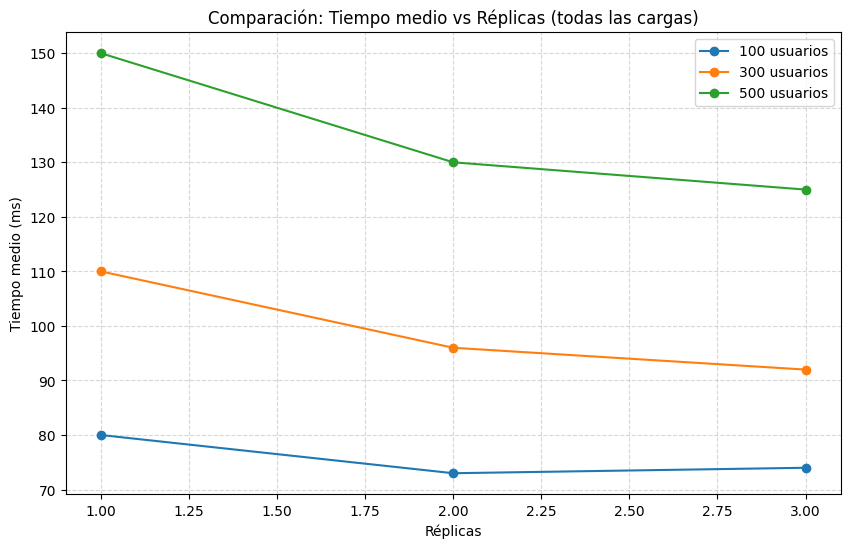

In [ ]:
plt.figure(figsize=(10,6))

for users in [100,300,500]:
    subset = df[df["Usuarios"] == users]
    plt.plot(subset["Replica"], subset["Media_ms"], marker="o", label=f"{users} usuarios")

plt.title("Comparación: Tiempo medio vs Réplicas (todas las cargas)")
plt.xlabel("Réplicas")
plt.ylabel("Tiempo medio (ms)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.show()


**Análisis gráficas anteriores:**

La gráfica comparativa evidencia claramente el impacto del escalamiento horizontal en el tiempo medio de respuesta del backend bajo distintos niveles de carga. Para 100 usuarios, la reducción entre 1 y 2 réplicas es ligera, y prácticamente no cambia entre 2 y 3, lo que sugiere que a cargas bajas el sistema no se encuentra limitado por recursos y la ganancia por añadir más pods es marginal. Sin embargo, a partir de 300 usuarios la diferencia se vuelve más marcada: el tiempo medio disminuye de 110 ms con una réplica a 96 ms con dos y a 92 ms con tres, reflejando que la distribución de carga empieza a aprovechar de forma real el escalamiento horizontal. El comportamiento es aún más evidente con 500 usuarios, donde el tiempo de respuesta baja de 150 ms a 130 ms y posteriormente a 125 ms; aunque las mejoras no son lineales, sí manifiestan que el backend obtiene beneficios al distribuir la concurrencia entre varias réplicas.

En conjunto, la gráfica demuestra que el escalamiento horizontal es más efectivo cuando la carga supera la capacidad de una sola réplica; es decir, los beneficios del escalamiento aumentan proporcionalmente a la presión sobre el sistema. Bajo cargas bajas, agregar réplicas no aporta mejoras significativas, pero bajo cargas medias y altas, el impacto es inmediato y sostenido. Esto confirma que Kubernetes utiliza eficazmente los recursos adicionales al distribuir los pods entre diferentes nodos, reduciendo la saturación y estabilizando la latencia conforme se incrementa el número de usuarios concurrentes.

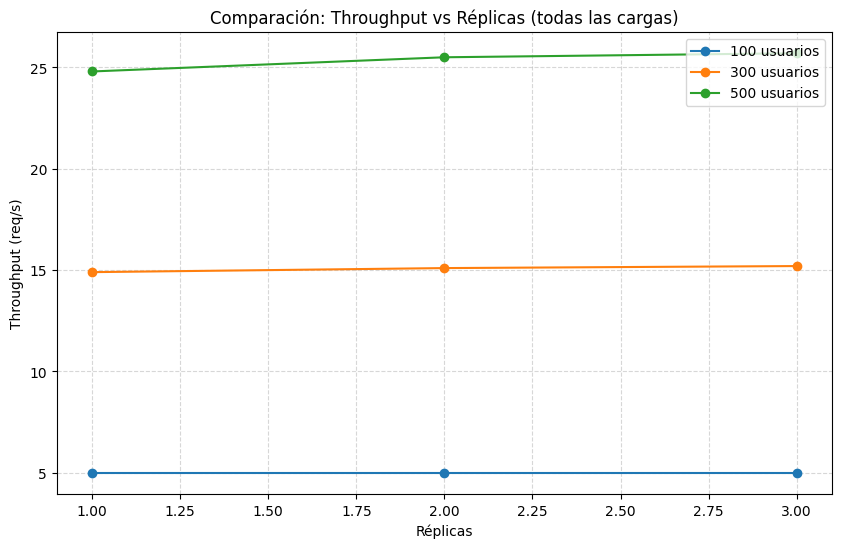

In [ ]:
plt.figure(figsize=(10,6))

for users in [100,300,500]:
    subset = df[df["Usuarios"] == users]
    plt.plot(subset["Replica"], subset["Throughput"], marker="o", label=f"{users} usuarios")

plt.title("Comparación: Throughput vs Réplicas (todas las cargas)")
plt.xlabel("Réplicas")
plt.ylabel("Throughput (req/s)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.show()


**Análisis gráficas anteriores:**

La gráfica comparativa de throughput evidencia que el incremento en la cantidad de réplicas tiene un efecto distinto dependiendo del nivel de carga aplicado al sistema. Para 100 usuarios, el throughput se mantiene prácticamente constante alrededor de 5 req/s sin importar si se utiliza 1, 2 o 3 réplicas, lo cual confirma que a cargas bajas el backend no se encuentra limitado por su capacidad de procesamiento; por tanto, añadir réplicas adicionales no ofrece un beneficio perceptible. En contraste, con 300 usuarios sí se observa un aumento moderado del throughput, pasando de 14.9 req/s con una réplica a 15.2 req/s con tres, reflejando una mejora en la capacidad del sistema para atender más solicitudes por segundo gracias a una distribución más eficiente de la carga entre múltiples pods.

El comportamiento más representativo se presenta con 500 usuarios, donde el throughput asciende significativamente desde 24.8 req/s con una réplica hasta 25.7 req/s con tres réplicas. Aunque la mejora no es explosiva, sí demuestra que el sistema responde mejor ante cargas elevadas cuando el backend escala horizontalmente. Esto implica que, a mayor demanda, Kubernetes aprovecha con mayor eficiencia las réplicas adicionales para procesar peticiones en paralelo, incrementando la capacidad global del servicio. En conjunto, la gráfica confirma que el escalamiento horizontal resulta más beneficioso cuando la carga se acerca o supera los límites naturales de una sola réplica, mientras que bajo cargas bajas el rendimiento se mantiene prácticamente inalterado independientemente del número de réplicas.

## Conclusiones



#### Fase 1:

Los resultados muestran que, aunque el sistema aumenta su capacidad de procesar solicitudes cuando se incrementa la carga, también lo hace a costa de tiempos de respuesta más altos. En cargas bajas el comportamiento es estable, pero a medida que los hilos crecen, los tiempos promedio y máximos se elevan, lo que indica que la aplicación empieza a trabajar al límite de sus recursos. Además, la variabilidad en los tiempos también sube, lo que significa que no todos los usuarios reciben la misma velocidad de respuesta bajo alta demanda.

A pesar de esa degradación, el throughput crece de manera constante en todos los escenarios, lo que demuestra que la aplicación sí escala y puede manejar más trabajo cuando se le exige. Sin embargo, el incremento fuerte en los tiempos máximos revela que algunas peticiones se vuelven mucho más lentas, lo cual es un signo claro de saturación en algún punto del sistema, ya sea en el backend o en la base de datos.

#### Fase 2:

En este ejercicio, el uso de un solo nodo para desplegar toda la arquitectura de Kubernetes (con namespaces separados para front y back y varios pods en forma de réplicas) permite demostrar el beneficio del escalado horizontal, pero a la vez deja claro que existe un límite físico impuesto por el propio nodo. Aumentar el número de réplicas distribuye mejor la carga entre pods y mejora el tiempo de respuesta, pero todos esos pods siguen compitiendo por los mismos recursos de CPU, memoria, red y disco del único nodo. Esto hace que, a partir de cierto punto, las mejoras al añadir más réplicas sean cada vez menores, porque el cuello de botella ya no es el número de pods, sino la capacidad total del nodo y, posiblemente, servicios compartidos como la base de datos.

Desde el punto de vista de diseño de arquitecturas, el ejercicio muestra que “escalar en pods” sin escalar también “en nodos” tiene un recorrido limitado. Funciona bien para cargas bajas o moderadas y es útil para observar cómo Kubernetes reparte el tráfico y mantiene la aplicación disponible, pero no representa un entorno verdaderamente distribuido ni altamente tolerante a fallos. Un único nodo implica un single point of failure: si ese nodo cae, desaparecen todas las réplicas de front y back. Además, en escenarios de mayor carga, el rendimiento quedará condicionado por la capacidad de ese único host, por lo que, para un sistema de tienda online en producción, sería necesario dar el siguiente paso: incorporar más nodos al clúster, distribuir los pods entre ellos y complementar el escalado horizontal de réplicas con un escalado real de la infraestructura subyacente.

#### Fase 3:

El análisis de rendimiento evidencia que la aplicación presenta un comportamiento estable bajo cargas bajas y medias, pero comienza a mostrar mejoras significativas en la respuesta cuando se incrementa el número de réplicas del backend al enfrentar cargas más elevadas. En escenarios de baja concurrencia, una sola réplica es suficiente para atender a los usuarios sin degradación perceptible en los tiempos de respuesta ni en el throughput, lo que demuestra que el sistema no está limitado por capacidad en estos casos. Sin embargo, conforme aumentan los usuarios concurrentes, el escalamiento horizontal se vuelve fundamental: con 300 y especialmente con 500 usuarios, incrementar de una a dos y luego a tres réplicas reduce la latencia y mejora el throughput, lo que confirma que la distribución de carga entre múltiples pods es efectiva para sostener incrementos en la demanda.

La ejecución de la Fase 3 en un clúster multinodo permitió observar un beneficio adicional: al disponer de más de un nodo físico, Kubernetes puede distribuir las réplicas entre gp7, gp25 y gp16, evitando que la carga se concentre en un solo servidor. Esto reduce el riesgo de saturación y mejora la capacidad general de procesamiento. De esta forma, se concluye que la combinación de múltiples réplicas y múltiples nodos incrementa notablemente la escalabilidad del sistema, al permitir paralelizar el procesamiento y balancear la carga de forma más eficiente que en el escenario de un solo nodo. En términos generales, tanto la reducción del tiempo medio de respuesta como el aumento en el throughput evidencian que la aplicación se beneficia claramente del escalamiento horizontal y del despliegue multinodo.

## Recomendaciones basadas en el análisis

Con base en los resultados obtenidos, se recomienda mantener un mínimo de dos réplicas del backend para cargas de usuario moderadas, ya que esta configuración proporciona mejoras en el tiempo de respuesta con un coste razonable de recursos. Para cargas altas o escenarios donde se espera un crecimiento en la demanda, es aconsejable escalar a tres réplicas o más, dependiendo de la capacidad del clúster, especialmente si se dispone de múltiples nodos que permitan distribuir eficientemente los pods. También se recomienda habilitar políticas de autoescalado (HPA – Horizontal Pod Autoscaler) que ajusten dinámicamente el número de réplicas según el uso de CPU o la cantidad de solicitudes, lo cual permitiría adaptar el rendimiento del sistema sin intervención manual.

Asimismo, se sugiere complementar el monitoreo con herramientas como Prometheus y Grafana para analizar en tiempo real métricas asociadas al desempeño del backend, ya que esto facilita la identificación temprana de cuellos de botella y zonas de saturación.